In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image

from sklearn.metrics import classification_report

from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, concatenate, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from tensorflow.keras import callbacks


In [45]:
train_path = "/home/hasan/Desktop/Code to keep on Github/Blood Cell Classification/dataset2-master/images/TRAIN"
test_path = "/home/hasan/Desktop/Code to keep on Github/Blood Cell Classification/dataset2-master/images/TEST"
test_sample_path = "/home/hasan/Desktop/Code to keep on Github/Blood Cell Classification/dataset2-master/images/TEST_SIMPLE"


### Some Images of EOSINOPHIL

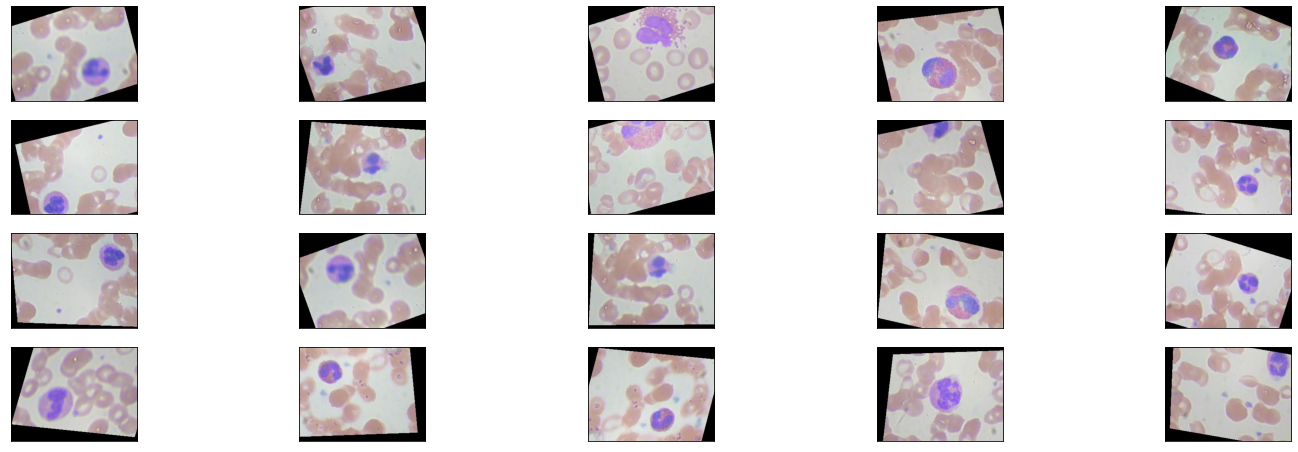

In [46]:
train_img = os.listdir(train_path + "/EOSINOPHIL")

fig = plt.figure(figsize=(25,8))
for idx, img in enumerate(np.random.choice(train_img, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(train_path+"/EOSINOPHIL/" + img)
    plt.imshow(im)

### Some Images of LYMPHOCYTE

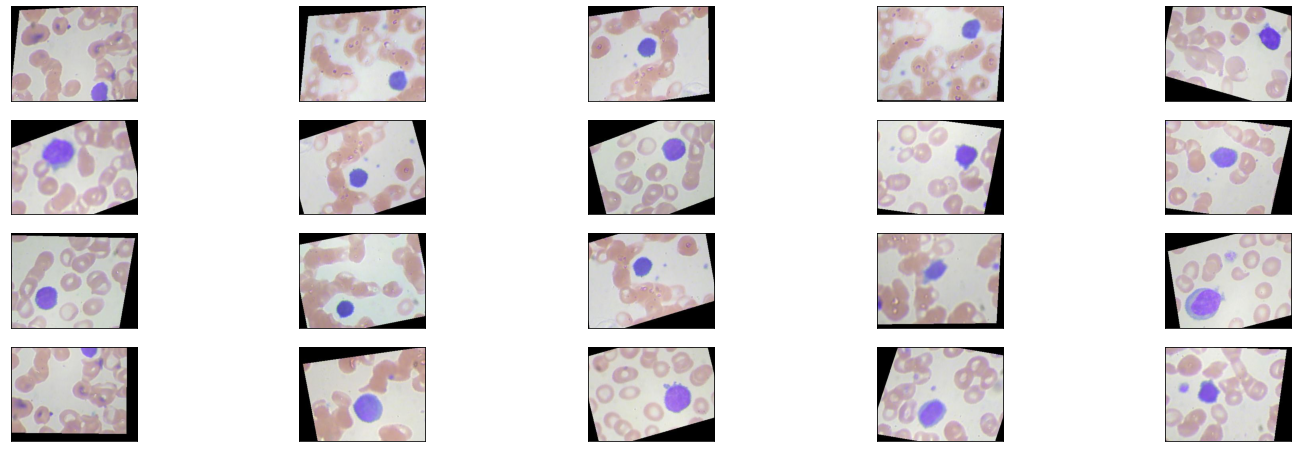

In [47]:
train_img = os.listdir(train_path + "/LYMPHOCYTE")

fig = plt.figure(figsize=(25,8))
for idx, img in enumerate(np.random.choice(train_img, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(train_path+"/LYMPHOCYTE/" + img)
    plt.imshow(im)

### Some Images of MONOCYTE

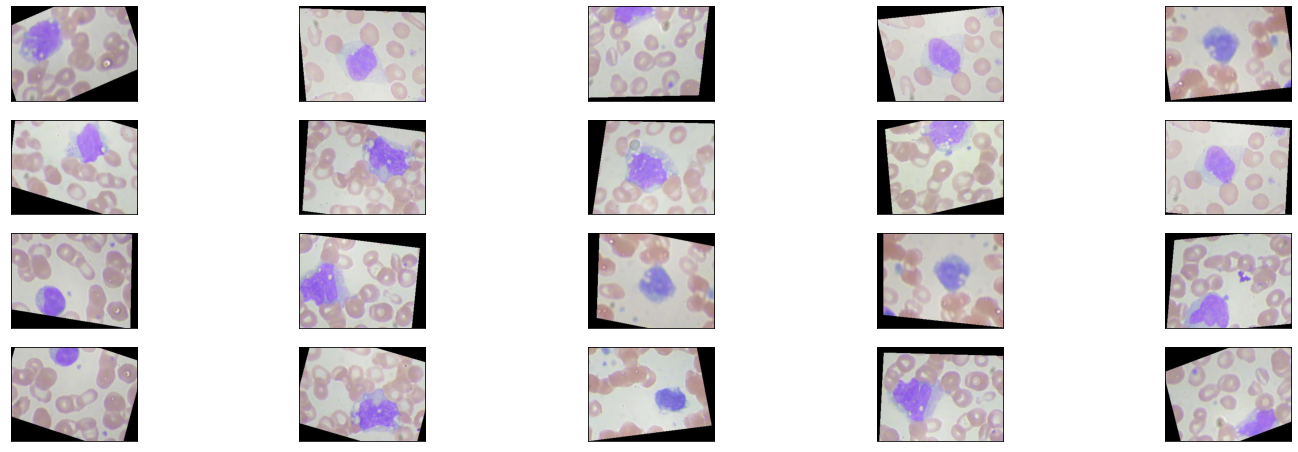

In [48]:
train_img = os.listdir(train_path + "/MONOCYTE")

fig = plt.figure(figsize=(25,8))
for idx, img in enumerate(np.random.choice(train_img, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(train_path+"/MONOCYTE/" + img)
    plt.imshow(im)

### Some Images of NEUTROPHIL

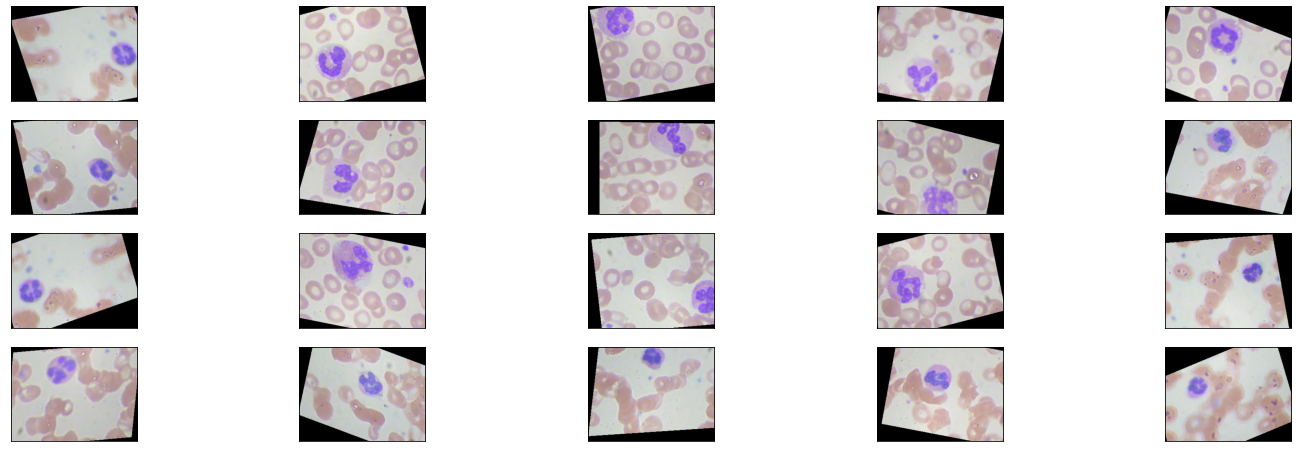

In [49]:
train_img = os.listdir(train_path + "/NEUTROPHIL")

fig = plt.figure(figsize=(25,8))
for idx, img in enumerate(np.random.choice(train_img, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(train_path+"/NEUTROPHIL/" + img)
    plt.imshow(im)

### Image Data Generator

In [50]:
train_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)


In [51]:
train_generator = train_gen.flow_from_directory(
     train_path,
     target_size=(128, 128),
     color_mode = 'rgb',
     batch_size = 32, 
     shuffle = True,
     seed = None, 
     class_mode = 'categorical')

test_generator = test_gen.flow_from_directory(
     test_path,
     target_size = (128, 128),
     color_mode = 'rgb',
     batch_size = 32,
     shuffle = True,
     seed = None,
     class_mode = 'categorical') 


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


### Model

In [52]:
def fire(x, squeeze, expand):
    y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y  = BatchNormalization(momentum=0.85)(y)
    y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = BatchNormalization(momentum=0.85)(y1)
    y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = BatchNormalization(momentum=0.85)(y3)
    return concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)


In [53]:
input_data = Input(shape=[128, 128, 3])
output = BatchNormalization(center=True, scale=False)(input_data)
output = Activation('relu')(output)
output = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(output)
output = BatchNormalization(momentum=0.85)(output)

output = fire_module(12, 24)(output)
output = MaxPooling2D(pool_size=2)(output)

output = fire_module(24, 48)(output)
output = MaxPooling2D(pool_size=2)(output)

output = fire_module(32, 64)(output)
output = MaxPooling2D(pool_size=2)(output)

output = fire_module(24, 48)(output)
output = MaxPooling2D(pool_size=2)(output)

output = fire_module(18, 36)(output)
output = MaxPooling2D(pool_size=2)(output) 

output = fire_module(12, 24)(output) 

output = GlobalAveragePooling2D()(output)
output = Dense(4, activation='sigmoid')(output)


model = Model(inputs=input_data, outputs=output)   
                                                                                                

In [54]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 128, 128, 3)  9           input_6[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 128, 128, 3)  0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 12) 912         activation_4[0][0]               
_______________________________________________________________________________________

### Callback Function

In [56]:
callback = callbacks.TerminateOnNaN()

### Model Training

In [59]:
train_step_size = train_generator.n // train_generator.batch_size
test_step_size = test_generator.n // test_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_step_size,
    epochs = 20,
    validation_data = test_generator,
    validation_steps = test_step_size,
    callbacks = [callback])


Epoch 1/20
311/311 [==============================] - 466s 1s/step - loss: 0.7104 - accuracy: 0.2347 - val_loss: 0.7118 - val_accuracy: 0.2378
Epoch 2/20
311/311 [==============================] - 455s 1s/step - loss: 0.6936 - accuracy: 0.2654 - val_loss: 0.7014 - val_accuracy: 0.2468
Epoch 3/20
311/311 [==============================] - 459s 1s/step - loss: 0.6804 - accuracy: 0.2898 - val_loss: 0.6909 - val_accuracy: 0.2565
Epoch 4/20
311/311 [==============================] - 529s 2s/step - loss: 0.6682 - accuracy: 0.3191 - val_loss: 0.6816 - val_accuracy: 0.2821
Epoch 5/20
311/311 [==============================] - 491s 2s/step - loss: 0.6567 - accuracy: 0.3439 - val_loss: 0.6667 - val_accuracy: 0.2971
Epoch 6/20
311/311 [==============================] - 489s 2s/step - loss: 0.6440 - accuracy: 0.3765 - val_loss: 0.6572 - val_accuracy: 0.3121
Epoch 7/20
311/311 [==============================] - 473s 2s/step - loss: 0.6299 - accuracy: 0.4045 - val_loss: 0.6482 - val_accuracy: 0.3356

### Accuracy and Loss Graph

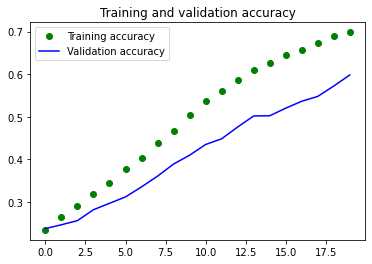

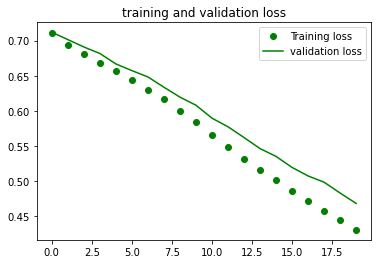

In [62]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()
